In [1]:
import os
import glob
import numpy as np
import pandas as pd
from tensorboard.backend.event_processing.event_accumulator import EventAccumulator

from matplotlib import pyplot as plt
import seaborn as sns
from scipy import stats

In [2]:
def tflog2pandas(path: str) -> pd.DataFrame:
    """convert single tensorflow log file to pandas DataFrame
    Parameters
    ----------
    path : str
        path to tensorflow log file
    Returns
    -------
    pd.DataFrame
        converted dataframe
    """
    DEFAULT_SIZE_GUIDANCE = {
        "compressedHistograms": 1,
        "images": 1,
        "scalars": 0,  # 0 means load all
        "histograms": 1,
    }
    runlog_data = pd.DataFrame({"metric": [], "value": [], "step": []})
    try:
        event_acc = EventAccumulator(path, DEFAULT_SIZE_GUIDANCE)
        event_acc.Reload()
        tags = event_acc.Tags()["scalars"]
        for tag in tags:
            event_list = event_acc.Scalars(tag)
            values = list(map(lambda x: x.value, event_list))
            step = list(map(lambda x: x.step, event_list))
            r = {"metric": [tag] * len(step), "value": values, "step": step}
            r = pd.DataFrame(r)
            runlog_data = pd.concat([runlog_data, r])
    # Dirty catch of DataLossError
    except Exception:
        print("Event file possibly corrupt: {}".format(path))
        traceback.print_exc()
    return runlog_data

In [41]:
def get_tblogs(data_id):
    root_dir = "/home/ubuntu/ray_results/PPO"
    exp_path = glob.glob(os.path.join(root_dir, "*" + data_id + "*", "event*"))
    if len(exp_path) > 1:
        print("Error: more than one experiments with that id found")
    df = tflog2pandas(exp_path[0])
    df = df.pivot(index="step", columns="metric")
    df_mean = df.filter(regex=(".*(custom_metrics|reward).*_mean"))
    df_mean = df_mean.rename(columns={x: x[24:-5] if "custom_metrics" in x else x[9:-5] for _,x in df.columns})
    return df_mean

In [45]:
def gen_plot_func(regex, title="", xlabel="", ylabel="", ylim=None, figure=True):
    def plot_func(df):
        if figure:
            plt.figure()
        plt.plot(df.filter(regex=(regex)))
        plt.ylim(ylim)
        plt.title(title)
        plt.xlabel(xlabel)
        plt.ylabel(ylabel)
    return plot_func

In [56]:
def step_average(a, steps):
    b = np.zeros(a.shape)
    c = 0
    for i in range(len(a)):
        c += a[i]
        if i >= steps:
            c -= a[i-steps]
        b[i] = c / min(steps, i+1)
    return b

In [60]:
df_rl = get_tblogs("eb07f")

In [61]:
df_alg = get_tblogs("7eb94")

In [62]:
dfs = [df_rl, df_alg]

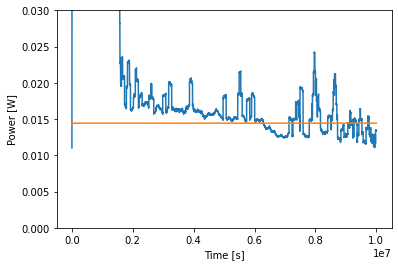

In [64]:
list(map(gen_plot_func(".*cost/energy", ylim=[0, 0.03], figure=False, xlabel="Time [s]", ylabel="Power [W]"), dfs));

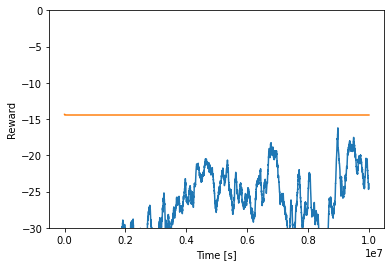

In [65]:
list(map(gen_plot_func(".*reward", ylim=[-30, 0], figure=False, xlabel="Time [s]", ylabel="Reward"), dfs));

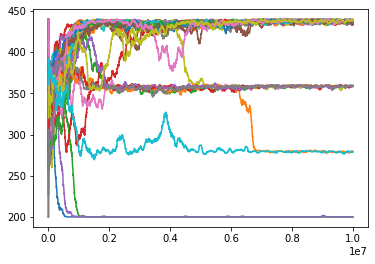

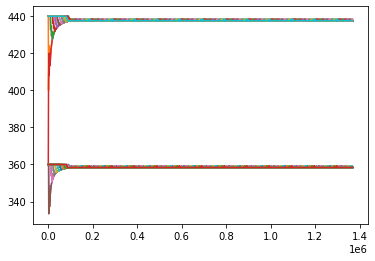

In [23]:
list(map(gen_plot_func(".*srv\d+/load"), dfs));

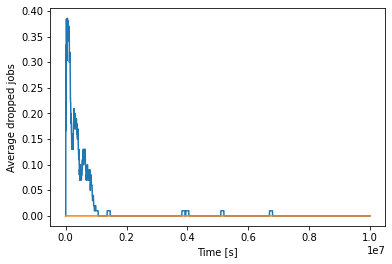

In [68]:
list(map(gen_plot_func(".*job/dropped", figure=False, xlabel="Time [s]", ylabel="Average dropped jobs"), dfs));

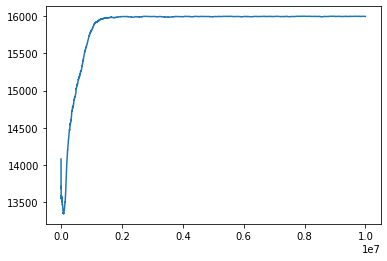

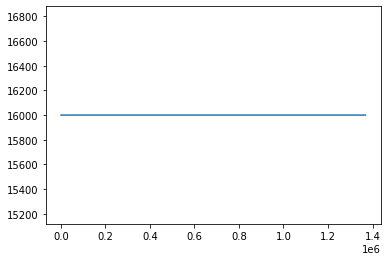

In [26]:
list(map(gen_plot_func(".*power/total_server_load"), dfs));

In [74]:
np.unique(df_rl.filter(regex=("cost/dropped")).to_numpy()) / 10 * 1000

array([  0.        ,  10.00000015,  20.0000003 ,  30.00000119,
        40.0000006 ,  50.        ,  60.00000238,  69.99999881,
        80.00000119,  89.99999762, 100.        , 110.00000238,
       120.00000477, 129.99999523, 139.99999762, 150.        ,
       160.00000238, 166.66666269, 170.00000477, 176.47058964,
       179.99999523, 181.81818724, 187.5       , 189.99999762,
       200.        , 209.99999046, 210.52632332, 214.28570747,
       220.00000477, 222.22223282, 229.99999523, 230.76922894,
       240.00000954, 250.        , 259.99999046, 270.00000477,
       279.99999523, 285.71429253, 290.00000954, 300.        ,
       303.03030014, 304.34782505, 309.99999046, 311.11111641,
       312.5       , 314.28570747, 315.78948498, 318.18182468,
       319.14894581, 320.00000477, 322.58064747, 323.52941036,
       324.32432175, 325.        , 325.58138371, 326.53062344,
       329.99999523, 333.33332539, 340.00000954, 341.17646217,
       341.46342278, 344.4444418 , 344.82758045, 345.23

In [77]:
df = get_tblogs("42aaa")

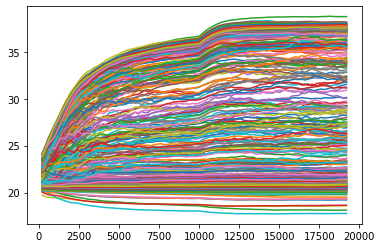

In [78]:
gen_plot_func("srv\d+/temp_in")(df)

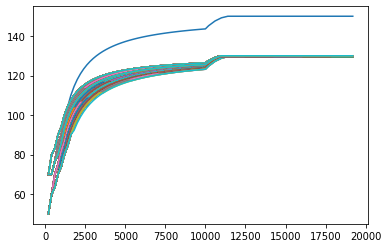

In [79]:
gen_plot_func("srv\d+/load")(df)